# STEP 02: Data exploration, Weather Version 001

In this notebook, the data exploration of the **weather data** is covered. There are three data sources that are being explored:

1. Weather: Information on temperature, cloud coverage, precipitation, etc at the location using the DarkSkyAPI
2. Sun position: Information on the position of the sun in the sky at the location using pysolar.solar
3. Solar panel production: Information on the amount of energy produced by the solar panels at the location

In [5]:
import datetime
import numpy as np
import pandas as pd
import requests
import re
import json
import os
from dateutil import tz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Load data


In [6]:
# import the data
path_to_jsons = './data/DarkSkyAPI/'
data = pd.read_csv(f'{path_to_jsons}/darkSkyData_cleaned_extracted.csv', index_col = 0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')
print(data.head())

                     apparentTemperature  cloudCover  humidity  \
2017-10-01 00:00:00                10.99        0.75      0.94   
2017-10-01 01:00:00                11.07         NaN      0.93   
2017-10-01 02:00:00                10.87         NaN      0.92   
2017-10-01 03:00:00                10.77         NaN      0.92   
2017-10-01 04:00:00                10.47         NaN      0.91   

                     precipAccumulation  precipIntensity  precipProbability  \
2017-10-01 00:00:00                 NaN             0.07               0.46   
2017-10-01 01:00:00                 NaN             0.02               0.16   
2017-10-01 02:00:00                 NaN             0.00               0.00   
2017-10-01 03:00:00                 NaN             0.00               0.00   
2017-10-01 04:00:00                 NaN             0.00               0.00   

                    precipType  pressure  temperature  uvIndex  visibility  \
2017-10-01 00:00:00       rain   1021.82        10

# 1. Missing value treatment


In [7]:
print(f'There are {data.shape[0]} rows')
print(f'Missing values in each column:')
print(data.isna().sum())
print(f'Missing values in each column in percent of total number of rows:')
print(100*data.isna().sum()/data.shape[0])

There are 15288 rows
Missing values in each column:
apparentTemperature      477
cloudCover              3963
humidity                 477
precipAccumulation     14864
precipIntensity          968
precipProbability        968
precipType              9191
pressure                 970
temperature              477
uvIndex                 1941
visibility              2186
windSpeed                549
dtype: int64
Missing values in each column in percent of total number of rows:
apparentTemperature     3.120094
cloudCover             25.922292
humidity                3.120094
precipAccumulation     97.226583
precipIntensity         6.331763
precipProbability       6.331763
precipType             60.119048
pressure                6.344846
temperature             3.120094
uvIndex                12.696232
visibility             14.298796
windSpeed               3.591052
dtype: float64


For the precip there are a lot of NaN values, which is not very surprising, since they only make sense when there is snow, or rain. For continuous variables such as temperature, humidity, etc, there should be no missing values. However, we also introduced some new rows with NaN in the previous notebook. Hence it is also not surprising that some amount of data (477) rows, contain missing values for continuous variables. We will impute these values by interpolating between the two nearest datapoints.

Let us treat the missing values for the continuous variables first by fitting a polynomnial.

### apparentTemperature, cloudCover, humidity, pressure, temperature, uvIndex, visibility, windSpeed

Treating column apparentTemperature, plotting 2018-01 until 2018-08
Max and min values for this column are: 37.4 -12.83


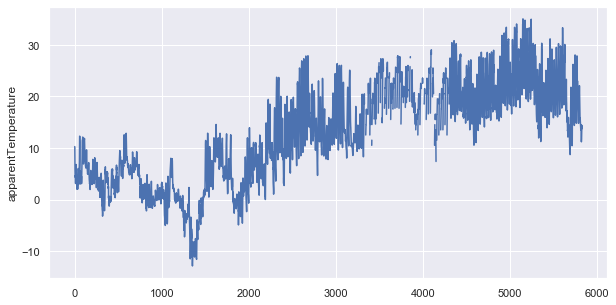

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


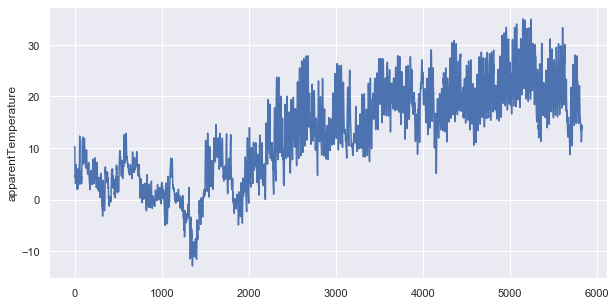

Treating column cloudCover, plotting 2018-01 until 2018-08
Max and min values for this column are: 1.0 0.0


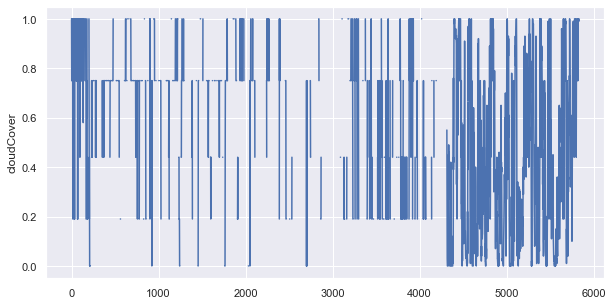

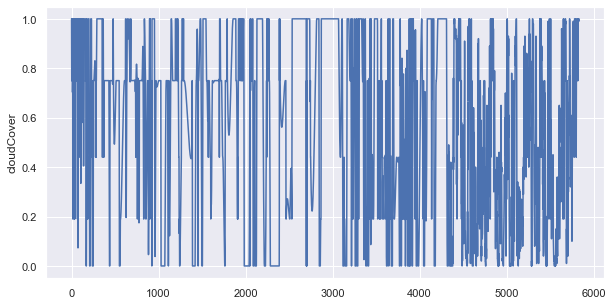

Treating column humidity, plotting 2018-01 until 2018-08
Max and min values for this column are: 1.0 0.2


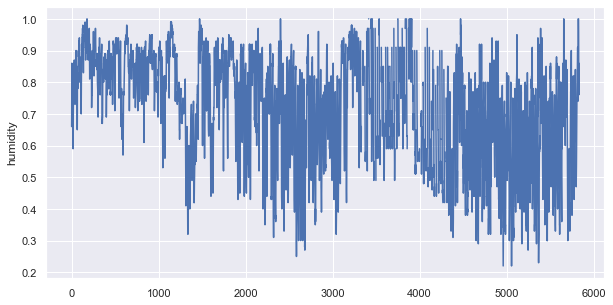

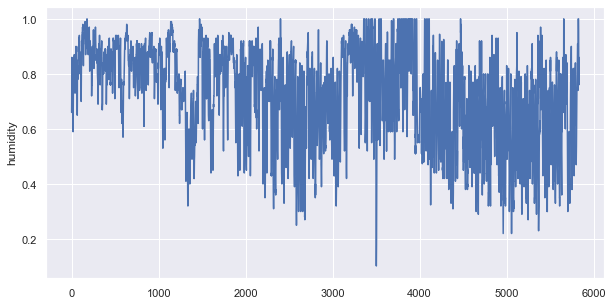

Treating column pressure, plotting 2018-01 until 2018-08
Max and min values for this column are: 1040.13 982.65


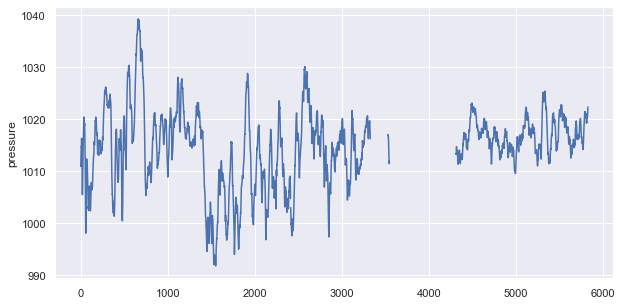

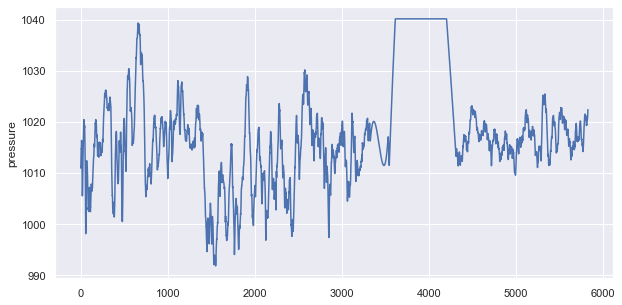

Treating column temperature, plotting 2018-01 until 2018-08
Max and min values for this column are: 35.4 -11.55


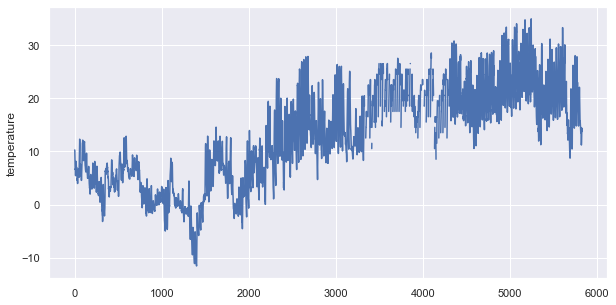

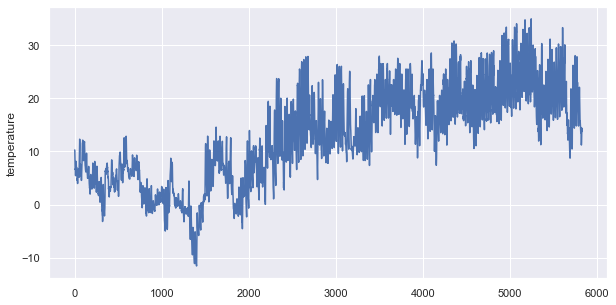

Treating column uvIndex, plotting 2018-01 until 2018-08
Max and min values for this column are: 9.0 0.0


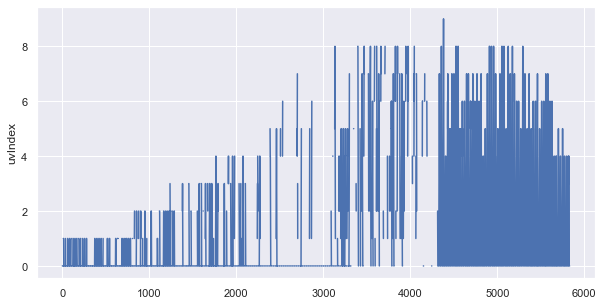

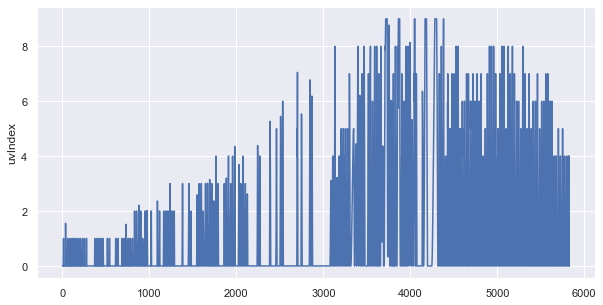

Treating column visibility, plotting 2018-01 until 2018-08
Max and min values for this column are: 16.093 0.0


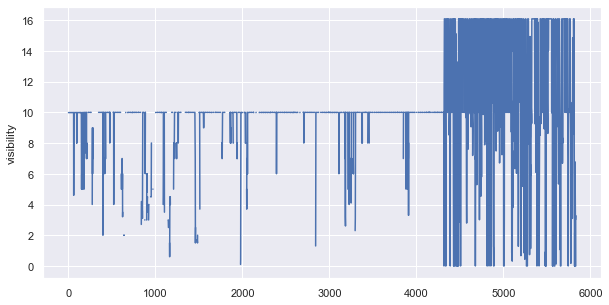

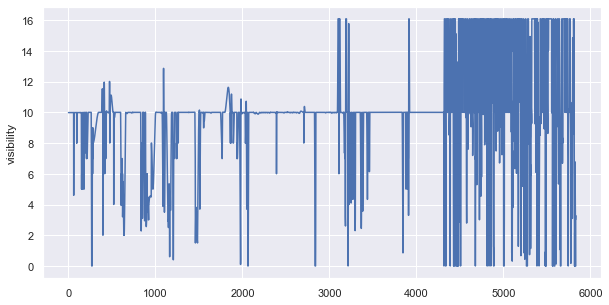

Treating column windSpeed, plotting 2018-01 until 2018-08
Max and min values for this column are: 15.07 0.0


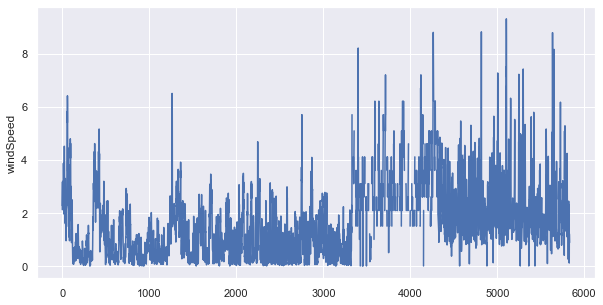

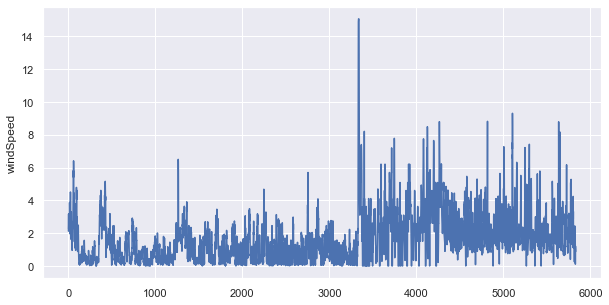

In [8]:
cols = ['apparentTemperature', 'cloudCover', 'humidity', 'pressure', 'temperature', 'uvIndex', 'visibility', 'windSpeed']
for col in cols:
    print(f'Treating column {col}, plotting 2018-01 until 2018-08')
    max_t = data[col].max()
    min_t = data[col].min()
    print(f'Max and min values for this column are: {max_t} {min_t}')
    s=data.loc['2018-01':'2018-08'][col]
    plt.figure(figsize=(10,5))
    plt.plot(s.values)
    plt.ylabel(col)

    plt.show()
    
    # interpolate
    data[col] = data[col].interpolate(method='polynomial', order=3)
    # prevent negative values for certain columns
    if min_t >= 0:
#         print(col)
        data[col] = data[col].clip(lower=0,upper=None)

    # prevent extreme values by ceiling them to the maximum
    data[col][data[col]>max_t] = max_t
    
    s=data.loc['2018-01':'2018-08'][col]
    plt.figure(figsize=(10,5))
#     print(s)
    plt.plot(s.values)
    plt.ylabel(col)
    plt.show()


In [9]:
print(data.isna().sum())

apparentTemperature        0
cloudCover                 0
humidity                   0
precipAccumulation     14864
precipIntensity          968
precipProbability        968
precipType              9191
pressure                   0
temperature                0
uvIndex                    0
visibility                 0
windSpeed                  0
dtype: int64


### The precipitation columns:

- precipAccumulation 
    - The amount of snowfall accumulation expected to occur, in inches. (If no snowfall is expected, this property will not be defined.)
      
      
- precipIntensity optional
    - The intensity (in inches of liquid water per hour) of precipitation occurring at the given time. This value is conditional on probability (that is, assuming any precipitation occurs at all).


- precipProbability optional
    - The probability of precipitation occurring, between 0 and 1, inclusive.


- precipType optional
    - The type of precipitation occurring at the given time. If defined, this property will have one of the following values: "rain", "snow", or "sleet" (which refers to each of freezing rain, ice pellets, and “wintery mix”). (If precipIntensity is zero, then this property will not be defined. Additionally, due to the lack of data in our sources, historical precipType information is usually estimated, rather than observed.)
    
    

### precipAccumulation: Set to 0
if there is no snow, there is no accumulation anyways. We will fill the values in these rows for that column with 0.

In [10]:
data['precipType'].unique()

array(['rain', nan, 'snow', 'sleet'], dtype=object)

In [11]:
rows = data[data['precipAccumulation'].isnull()].index
data.loc[rows,'precipAccumulation'] = 0
assert len(data[data['precipAccumulation'].isnull()]) == 0

### precipType, precipIntensity, and precipProbability
Must be nonzero if precipIntensity is nonzero. Else it will be set to 0. precipProbability will be set to 0 for nonzero

In [12]:
rows = data[(data['precipIntensity'] > 0) & (data['precipType'] == np.nan)]
assert len(rows) == 0

rows = data[data['precipIntensity'].isnull()].index
data.loc[rows,'precipIntensity'] = 0
rows = data[data['precipType'].isnull()].index
data.loc[rows,'precipType'] = 'None'
rows = data[data['precipProbability'].isnull()].index
data.loc[rows,'precipProbability'] = 0
assert len(data[data['precipIntensity'].isnull()]) == 0
assert len(data[data['precipType'].isnull()]) == 0
assert len(data[data['precipProbability'].isnull()]) == 0

In [13]:
# no more missing data
assert data.isna().sum().sum() == 0

# 2. Visualizations


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15288 entries, 2017-10-01 00:00:00 to 2019-06-29 23:00:00
Data columns (total 12 columns):
apparentTemperature    15288 non-null float64
cloudCover             15288 non-null float64
humidity               15288 non-null float64
precipAccumulation     15288 non-null float64
precipIntensity        15288 non-null float64
precipProbability      15288 non-null float64
precipType             15288 non-null object
pressure               15288 non-null float64
temperature            15288 non-null float64
uvIndex                15288 non-null float64
visibility             15288 non-null float64
windSpeed              15288 non-null float64
dtypes: float64(11), object(1)
memory usage: 2.1+ MB


The data ranges from October 2017 until June 2019, every row corresponds to one hour and there are no more missing values. There is only one categorical variable, `precipType` the other variables are float types.

## Precipitation

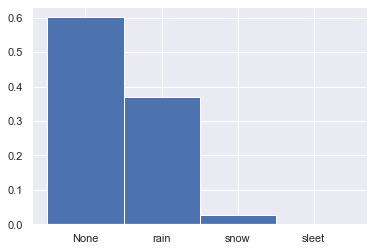

None     0.601190
rain     0.370879
snow     0.027734
sleet    0.000196
Name: precipType, dtype: float64

In [15]:
# different types of precipitation
s = data['precipType'].value_counts()
plt.bar(s.index,s.values/data.shape[0],width=1)
plt.show()
s/data.shape[0]

We can see that for 60% of the data (hours) there has been no precipitation. Around 35% of the data contains rain and only a small fraction (3%) is with snow. Sleet play almost no role with less than <0.1% of occurences.

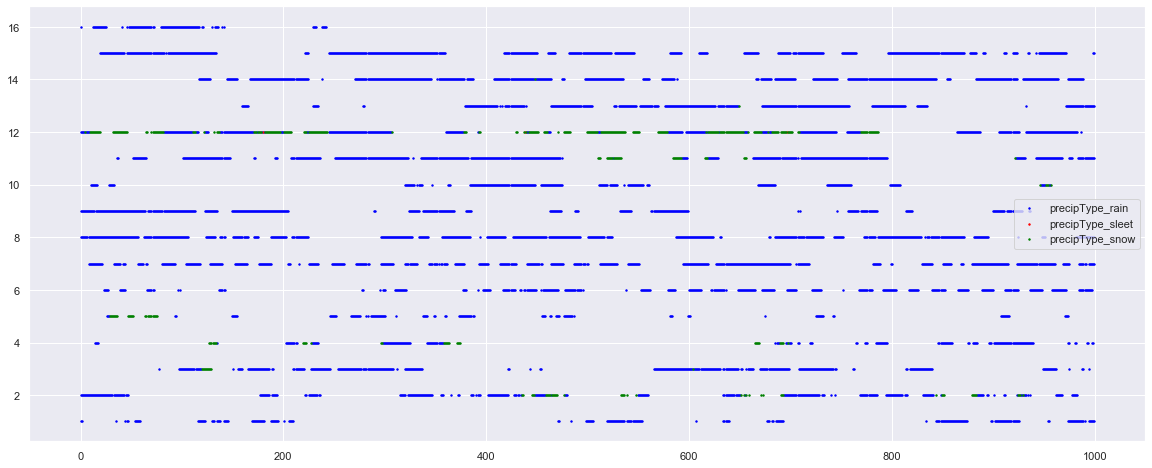

In [16]:
# investigate time series
# encoding
data = pd.get_dummies(data)
cols = [c for c in data.columns if 'precipType' in c]
precipTypes = data[cols]
# make lines with length of 100 at distinct y locations
locations = np.arange(0,17,1)
# chunk the data into dataframes of length 100
ii = 0
step = 1000
dfs = []
for loc in locations:
    chunk = precipTypes.iloc[ii:ii+step,:]
    chunk = chunk.drop('precipType_None', axis='columns')
    if len(chunk) > 0:
        dfs.append(chunk)
    ii = ii + step

# make different color based on precipType
colors = ['blue', 'red', 'green']
markers = ['x', 'o', 'd']
jj = 0
plt.figure(figsize=(20,8))
# loop through each dataframe
for y in locations[1:]:
    # y location is loc
    # reset the index
    df = dfs[jj].reset_index(drop=True)
    # loop through each of the three types
    for kk in range(0, len(df.columns)):
        # plot only these values that are 1 in the respective color
        rows = df[df[df.columns[kk]]==1].index
        X = rows.values
        # print(len(X))
        Y = np.empty(len(X))
        for ii in range(len(X)):
            Y[ii] = y
        if y == 1:
            plt.scatter(X,Y,color=colors[kk], label=df.columns[kk], s=2)
        else:
            plt.scatter(X,Y,color=colors[kk] ,s=2)
            
    jj = jj + 1
plt.legend()
plt.show()

We can see that the data is quite "patchy". Snow is typically clouded together, as one would assume in this region, where four seasons exist.

In [17]:
data['precipProbability'].describe()

count    15288.000000
mean         0.113830
std          0.235293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.080000
max          1.000000
Name: precipProbability, dtype: float64

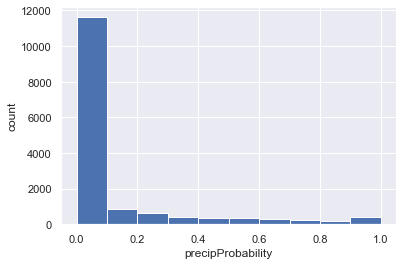

In [18]:
plt.hist(data['precipProbability'], bins=10)
plt.xlabel('precipProbability')
plt.ylabel('count')
plt.show()

In the investigated period, the probability of precipitation occuring was mostly 0. As a sanity check, let is see how often there was a probability of precipitation and it occured, and when it did not.

In [19]:
v = data[ (data['precipProbability'] > 0)].count()[0]
print(f'Rows where probability of precipitation > 0 : {v}')
v = data[ (data['precipProbability'] > 0) & (data['precipIntensity']>0) ].count()[0]
print(f'Rows where probability of precipitation > 0 and there was precipitation: {v}')
v = data[ (data['precipProbability'] > 0) & (data['precipIntensity']<=0) ].count()[0]
print(f'Rows where probability of precipitation > 0 and there was NO precipitation: {v}')

Rows where probability of precipitation > 0 : 5606
Rows where probability of precipitation > 0 and there was precipitation: 5606
Rows where probability of precipitation > 0 and there was NO precipitation: 0


Checking back with the documentation, it reads that: *The intensity (in inches of liquid water per hour) of precipitation occurring at the given time. This value is conditional on probability (that is, assuming any precipitation occurs at all).*

What this tells us that the variable precipProbability is not a good variable for our model, as it dependent on precipIntensity and will not add further predicting power on the solar panel production.

## Temperature

/Users/hkromer/anaconda3/envs/solarAnalytics/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


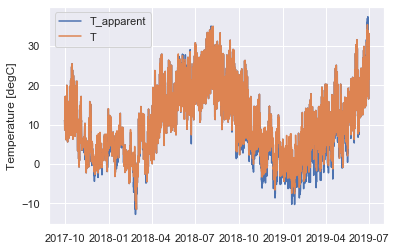

In [20]:
plt.plot(data.index, data['apparentTemperature'], label='T_apparent')
plt.plot(data.index, data['temperature'], label='T')
plt.legend()
plt.ylabel('Temperature [degC]')
plt.show()

By directly plotting the two variables, there is not much information over the around 2 years. However, one can plot the mean values to see the trends.

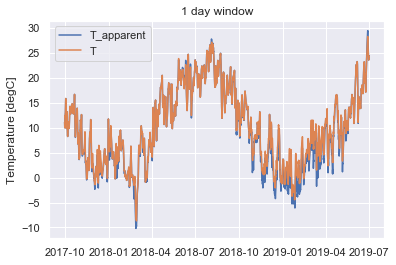

In [21]:
s = data['apparentTemperature'].rolling(window='1D').mean()
plt.plot(s.index, s.values, label='T_apparent')
s = data['temperature'].rolling(window='1D').mean()
plt.plot(s.index, s.values, label='T')
plt.legend()
plt.ylabel('Temperature [degC]')
plt.title('1 day window')
plt.show()

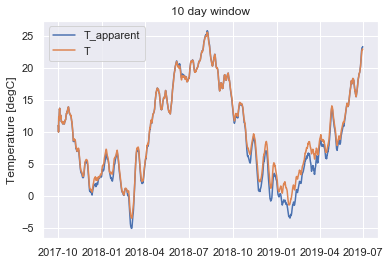

In [22]:
s = data['apparentTemperature'].rolling(window='10D').mean()
plt.plot(s.index, s.values, label='T_apparent')
s = data['temperature'].rolling(window='10D').mean()
plt.plot(s.index, s.values, label='T')
plt.legend()
plt.ylabel('Temperature [degC]')
plt.title('10 day window')
plt.show()

Unsurprisingly, the temperature is higher in the summer and lower in the winter months. Let us investigate the difference between the apparent temperature and the temperature. Note that wikipedia tells us the apparent temperature is 'Apparent temperature is the temperature equivalent perceived by humans, caused by the combined effects of air temperature, relative humidity and wind speed.'

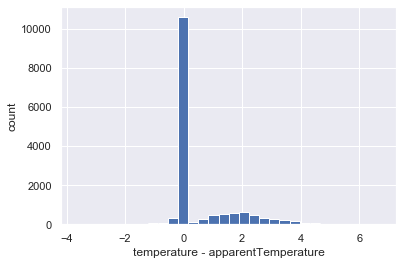

In [23]:
diffs = data['temperature']-data['apparentTemperature']
plt.hist(diffs, bins=30)
plt.xlabel('temperature - apparentTemperature')
plt.ylabel('count')
plt.show()

From the histogram of differences, the distribution is shifted to the right with mostly 0 difference between the temperature and the apparent one. However, if different, the apparent temperature is usually lower than the temperature. This is also reflected in the curves we saw earlier.

In [24]:
data[['temperature', 'apparentTemperature']].describe()

temperature  apparentTemperature
count  15288.000000         15288.000000
mean      10.188668             9.630202
std        8.141462             8.687869
min      -11.550000           -12.830000
25%        3.887500             2.680000
50%        9.210000             8.620000
75%       15.940000            15.960000
max       35.400000            37.400000

Interestingly, the maximum and minimum apparent temperatures was larger and respectively smaller than the respective temperature extrema in the observed period.

## Humidity

In [25]:
data['humidity'].describe()

count    15288.000000
mean         0.734108
std          0.159942
min          0.102194
25%          0.640000
50%          0.770000
75%          0.850000
max          1.000000
Name: humidity, dtype: float64

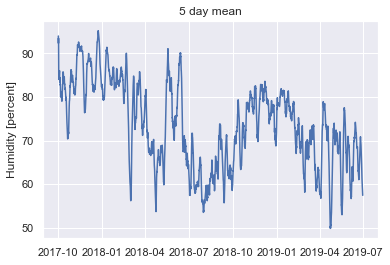

In [26]:
s = data['humidity'].rolling(window='5D').mean()
plt.plot(s.index, 100*s.values)
plt.ylabel('Humidity [percent]')
plt.title('5 day mean')
plt.show()

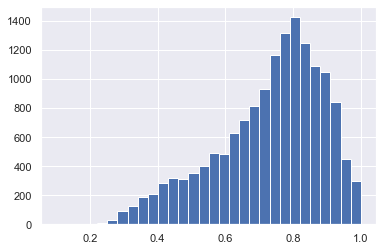

In [32]:
plt.hist(data['humidity'], bins=30)
plt.show()

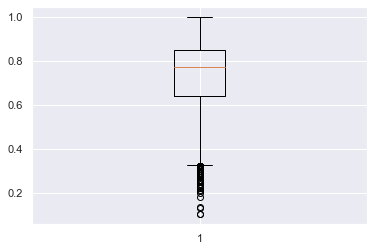

In [34]:
plt.boxplot(data['humidity'])
plt.show()

The humidity was mostly between 64 to 85 percent (25th through 75th percentile). The mean was 73 percent. Note that this is after the imputation of missing values.

## cloudCover

In [36]:
data['cloudCover'].describe()

count    15288.000000
mean         0.600504
std          0.364249
min          0.000000
25%          0.250000
50%          0.750000
75%          0.970000
max          1.000000
Name: cloudCover, dtype: float64

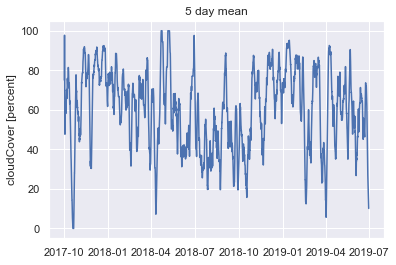

In [38]:
s = data['cloudCover'].rolling(window='5D').mean()
plt.plot(s.index, 100*s.values)
plt.ylabel('cloudCover [percent]')
plt.title('5 day mean')
plt.show()

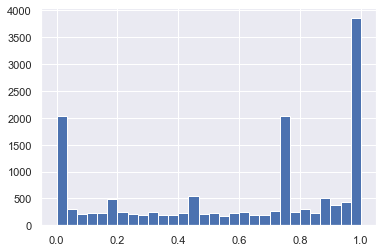

In [39]:
plt.hist(data['cloudCover'], bins=30)
plt.show()

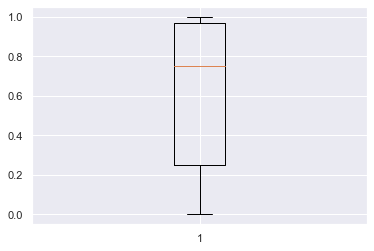

In [40]:
plt.boxplot(data['cloudCover'])
plt.show()

cloudCover has a long range, with the 25th through 75th percentile ranging from around 20 to almost 100 percent in the observed period

## pressure

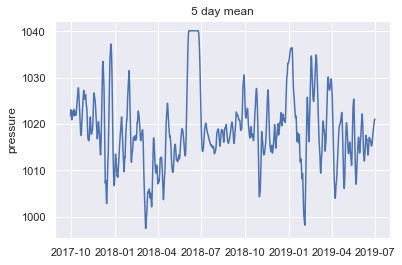

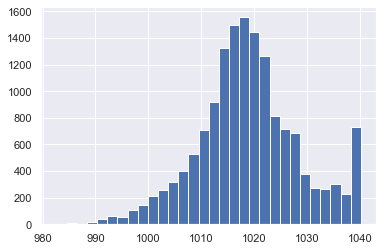

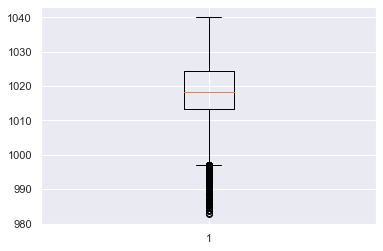

count    15288.000000
mean      1018.857537
std          9.697822
min        982.650000
25%       1013.360000
50%       1018.370000
75%       1024.210000
max       1040.130000
Name: pressure, dtype: float64

In [42]:
s = data['pressure'].rolling(window='5D').mean()
plt.plot(s.index, s.values)
plt.ylabel('pressure')
plt.title('5 day mean')
plt.show()
plt.hist(data['pressure'], bins=30)
plt.show()
plt.boxplot(data['pressure'])
plt.show()
data['pressure'].describe()


The pressure in hPa was between 982 and 1040. Note that in the period around July 2018, the values had to be ceiled during the interpolation and can probably not be trusted. During model development, different pipeline options should be explored

## uvIndex

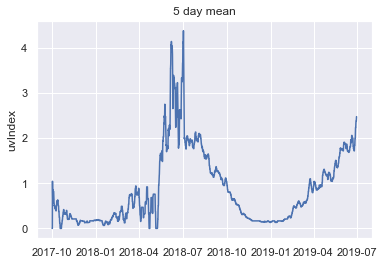

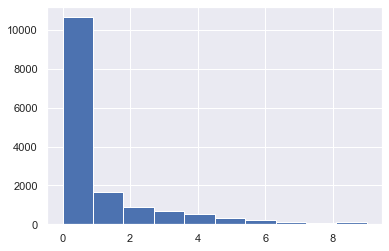

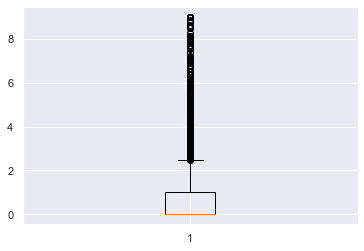

count    15288.000000
mean         0.861204
std          1.705614
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: uvIndex, dtype: float64

In [44]:
s = data['uvIndex'].rolling(window='5D').mean()
plt.plot(s.index, s.values)
plt.ylabel('uvIndex')
plt.title('5 day mean')
plt.show()
plt.hist(data['uvIndex'], bins=10)
plt.show()
plt.boxplot(data['uvIndex'])
plt.show()
data['uvIndex'].describe()


uvIndex takes values between 0 and 9. There were quite some missing values. This must also be taken into account during model development.

## visibility

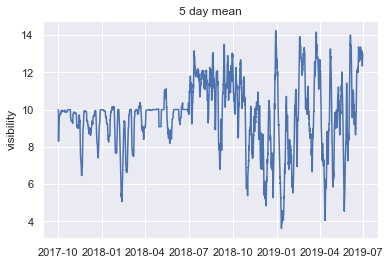

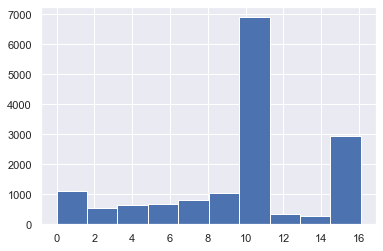

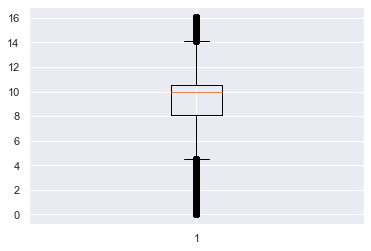

count    15288.000000
mean         9.658583
std          4.351782
min          0.000000
25%          8.131000
50%         10.000971
75%         10.520250
max         16.093000
Name: visibility, dtype: float64

In [45]:
s = data['visibility'].rolling(window='5D').mean()
plt.plot(s.index, s.values)
plt.ylabel('visibility')
plt.title('5 day mean')
plt.show()
plt.hist(data['visibility'], bins=10)
plt.show()
plt.boxplot(data['visibility'])
plt.show()
data['visibility'].describe()


The average visibility in km is mostly between 8 and 11.5 km (25th to 75th percentile). There are a lot of outliers on both end.

## windSpeed

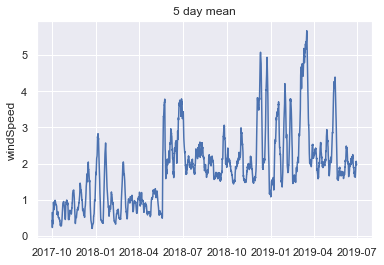

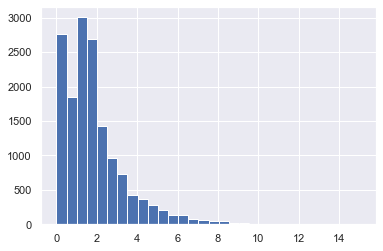

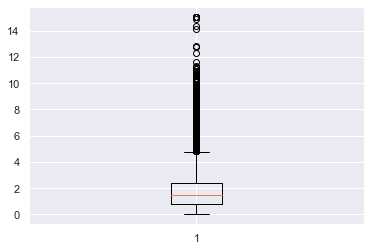

count    15288.000000
mean         1.857132
std          1.607462
min          0.000000
25%          0.820000
50%          1.510000
75%          2.410000
max         15.070000
Name: windSpeed, dtype: float64

In [47]:
s = data['windSpeed'].rolling(window='5D').mean()
plt.plot(s.index, s.values)
plt.ylabel('windSpeed')
plt.title('5 day mean')
plt.show()
plt.hist(data['windSpeed'], bins=30)
plt.show()
plt.boxplot(data['windSpeed'])
plt.show()
data['windSpeed'].describe()


The windSpeed in km per hour is mostly around 1 to 2 km/h. Notably is an offset in the values between Oct 2017 until June 2017 and the period after until July 2019.